# SECTION TWO - Classification with transfer learning (30%)


The task is again to train a classification model for CIFAR-10, but this time with transfer learning. Load
a model with pre-trained weights into your environment. You may choose any one of the available models
(VGG, Inception, ResNet, DenseNet, EfficientNet, etc.), but give a short motivation for your choice. Also
find out and explain how the difference in image dimensions between ImageNet and CIFAR-10 can be
handled.
Replace the pre-trained model’s classification layers with one or two new layers, freeze the weights of the

feature extraction (convolutional) layers, and train the new layers. You may also experiment with fine-
tuning all the convolutional layers. Compare training times and test accuracies with your best model from

Problem 1.

In [ ]:
#  PyTorch
import time
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset, random_split
import torch.nn.functional as F
#  torchvision
import torchvision
from torchvision import transforms, datasets
from torchsummary import summary
#  Ml libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## VGG 16

In [ ]:
### PRE-TRAINED MODELS AVAILABLE HERE
## https://pytorch.org/docs/stable/torchvision/models.html
from torchvision import models

#  loading vgg16
vgg = models.vgg16(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date we

I have chosen vgg because of its simplicity in architecture "repeated blocks of convolutional layers followed by pooling".which is similar to my best performing model.

also,the small filter sizes are best suited to the cifar 10 dataset

### PreProcess Data To be compatible with the VGG16 Model

This is how I dealt with the different data dimentions, resize the pictures to 224,224

In [ ]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
    transforms.Resize((224, 224)),
        transforms.ToTensor(),
        std_normalize])


batch_size = 128
train_ratio = 0.8
validation_ratio = 0.2
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#  preparing the data int train, valdation and test


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=trans)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=trans)

dataset_size = len(trainset)
train_size = int(train_ratio * dataset_size)
validation_size = dataset_size - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,

                                         shuffle=False, num_workers=2)

# Checking the dataset
for images, labels in trainloader:
    print('data dimensions:', images.shape)
    print('labels dimensions:', labels.shape)
    break

Files already downloaded and verified
Files already downloaded and verified
data dimensions: torch.Size([128, 3, 224, 224])
labels dimensions: torch.Size([128])


### Preparing The model for Transfer learning


I decided to freeze all layers , convolutional layers and the classifier's layers, then, replace the classifier with custom layers of my own

In [ ]:

#  freeze the whole model
for param in model.parameters():
    param.requires_grad = False
#  Approach 1 , replace the entire classifier
vgg.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 512),  # Input size lastt convolutional layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 10)
)
#  replace the last layer withmy own layers
# vgg.classifier[6] = nn.Sequential(nn.Linear(4096, 512),
#                       nn.ReLU(),
#                       nn.Dropout(0.5),
#                       nn.Linear(512, 10))
# move to gpu
vgg = vgg.to(device)
# summary(vgg, input_size=(3, 224, 224))
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Set up the loss funciton and the optimizer
optimizer = torch.optim.Adam(vgg.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

import time
tic = time.time()
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_model(vgg,epoch)
    model_validation(vgg,epoch,validationloader)
toc = time.time()
print(f" Training time = {toc-tic:.2f} seconds")
plot_metrics()

# Save the model
torch.save(vgg.state_dict(), 'vgg16.pth')


Epoch [0], Batch [0/313], Loss: 2.3216, Accuracy: 8.59%
Epoch [0], Batch [200/313], Loss: 2.3130, Accuracy: 10.29%
Epoch 0 Validation Loss: 1.9379, Validation Accuracy: 26.03%
Epoch [1], Batch [0/313], Loss: 1.9729, Accuracy: 26.56%
Epoch [1], Batch [200/313], Loss: 1.8160, Accuracy: 30.88%
Epoch 1 Validation Loss: 1.5689, Validation Accuracy: 42.03%
Epoch [2], Batch [0/313], Loss: 1.5924, Accuracy: 34.38%
Epoch [2], Batch [200/313], Loss: 1.5457, Accuracy: 43.00%
Epoch 2 Validation Loss: 1.3142, Validation Accuracy: 52.17%
Epoch [3], Batch [0/313], Loss: 1.3685, Accuracy: 56.25%
Epoch [3], Batch [200/313], Loss: 1.3112, Accuracy: 53.57%
Epoch 3 Validation Loss: 1.2504, Validation Accuracy: 55.73%
Epoch [4], Batch [0/313], Loss: 1.1271, Accuracy: 56.25%
Epoch [4], Batch [200/313], Loss: 1.1539, Accuracy: 59.04%
Epoch 4 Validation Loss: 1.0075, Validation Accuracy: 63.77%
Epoch [5], Batch [0/313], Loss: 1.1150, Accuracy: 53.12%
Epoch [5], Batch [200/313], Loss: 1.0317, Accuracy: 63.62%


#### Comment

Dissappointment, VGG16 modell doesnt learn as expected + takes too long to train

plan B : use efficient fast model : MobileNent

## Mobile Net


Motivation : small size, fast in training ,efficent

### Load Model + Prepare the Data


In [ ]:
### PRE-TRAINED MODELS AVAILABLE HERE
## https://pytorch.org/docs/stable/torchvision/models.html
from torchvision import models

mobilenet = models.mobilenet_v2(pretrained=True)

In [ ]:
mobilenet.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
    transforms.Resize((224, 224)),
        transforms.ToTensor(),
        std_normalize])


batch_size = 128
train_ratio = 0.8
validation_ratio = 0.2
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#  preparing the data int train, valdation and test


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=trans)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=trans)

dataset_size = len(trainset)
train_size = int(train_ratio * dataset_size)
validation_size = dataset_size - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,

                                         shuffle=False, num_workers=2)

# Checking the dataset
for images, labels in trainloader:
    print('data dimensions:', images.shape)
    print('labels dimensions:', labels.shape)
    break

Files already downloaded and verified
Files already downloaded and verified
data dimensions: torch.Size([128, 3, 224, 224])
labels dimensions: torch.Size([128])


In [ ]:
#  freeze the whole model
for param in mobilenet.parameters():
    param.requires_grad = False
#  Approach 1 , replace the entire classifier
mobilenet.classifier = nn.Sequential(
    nn.Linear(1280, 512),  # Input size lastt convolutional layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 10)
)
#  replace the last layer withmy own layers
# mobilenet.classifier[6] = nn.Sequential(nn.Linear(4096, 512),
#                       nn.ReLU(),
#                       nn.Dropout(0.5),
#                       nn.Linear(512, 10))
# move to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mobilenet = mobilenet.to(device)
summary(mobilenet, input_size=(3, 224, 224))
mobilenet

Epoch [0], Batch [0/313], Loss: 2.3065, Accuracy: 10.16%
Epoch [0], Batch [200/313], Loss: 1.3214, Accuracy: 52.27%
Epoch 0 Validation Loss: 0.7436, Validation Accuracy: 73.26%
Epoch [1], Batch [0/313], Loss: 0.9317, Accuracy: 71.09%
Epoch [1], Batch [200/313], Loss: 0.8634, Accuracy: 71.12%
Epoch 1 Validation Loss: 0.6841, Validation Accuracy: 76.37%
Epoch [2], Batch [0/313], Loss: 0.7575, Accuracy: 73.44%
Epoch [2], Batch [200/313], Loss: 0.8190, Accuracy: 72.97%
Epoch 2 Validation Loss: 0.6678, Validation Accuracy: 77.10%
Epoch [3], Batch [0/313], Loss: 0.8217, Accuracy: 71.88%
Epoch [3], Batch [200/313], Loss: 0.7766, Accuracy: 74.59%
Epoch 3 Validation Loss: 0.6532, Validation Accuracy: 77.30%
Epoch [4], Batch [0/313], Loss: 0.5366, Accuracy: 81.25%
Epoch [4], Batch [200/313], Loss: 0.7558, Accuracy: 75.21%
Epoch 4 Validation Loss: 0.6481, Validation Accuracy: 77.53%
Epoch [5], Batch [0/313], Loss: 0.5642, Accuracy: 78.91%
Epoch [5], Batch [200/313], Loss: 0.7300, Accuracy: 75.88%

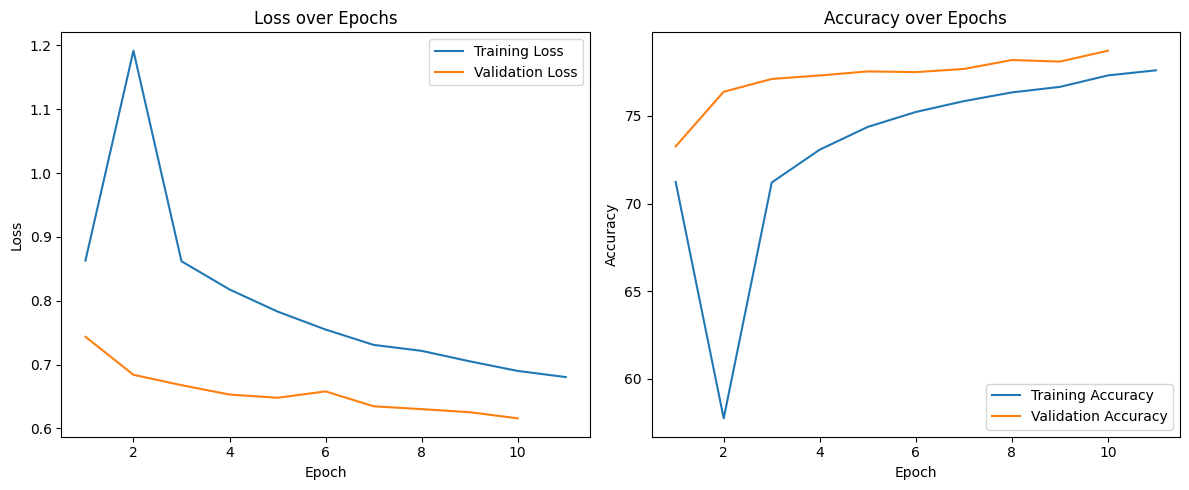

In [ ]:
# Set up the loss funciton and the optimizer
optimizer = torch.optim.Adam(mobilenet.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

import time
tic = time.time()
# Training loop
num_epochs = 10
for epoch in range(10,2*num_epochs):
    train_model(mobilenet,epoch)
    model_validation(mobilenet,epoch,validationloader)
toc = time.time()
print(f" Training time = {toc-tic:.2f} seconds")
plot_metrics()

# Save the model
torch.save(mobilenet.state_dict(), 'mobilenet16.pth')


#### Comment :

better than vgg, but still did not do the best

## mobilenet_v3_large :

Method2 : Replacing only one layer from the classifier

In [ ]:
mobilenet2 = models.mobilenet_v3_large(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 87.8MB/s]


In [ ]:
mobilenet2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

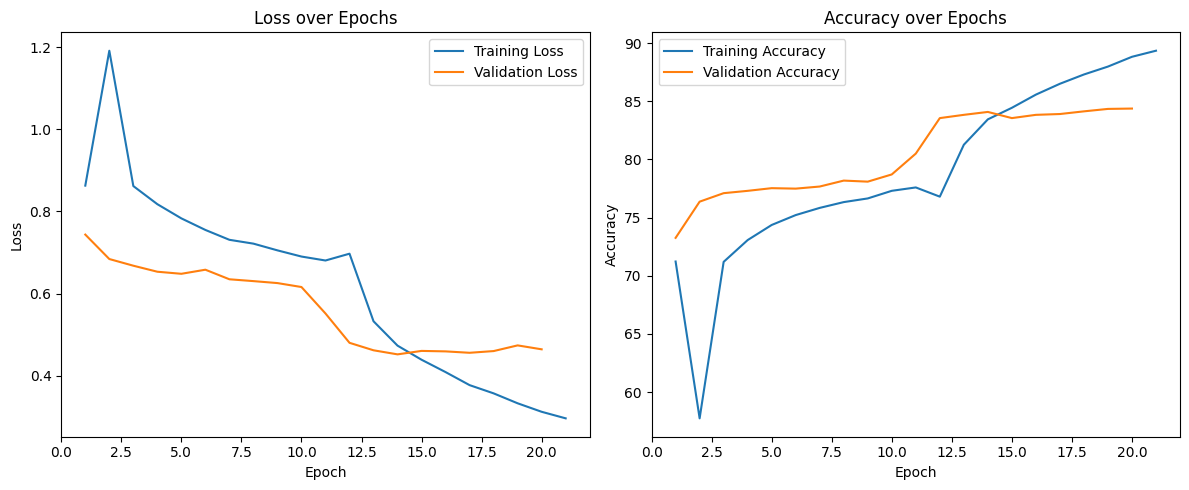

In [ ]:

#  freeze the whole model
for param in mobilenet2.parameters():
    param.requires_grad = False
#  Approach 1 , replace the entire classifier
# mobilenet2.classifier = nn.Sequential(
#     nn.Linear(1280, 512),  # Input size lastt convolutional layer
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(512, 64),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(64, 10)
# )
#  replace the last layer withmy own layers
mobilenet2.classifier[3] = nn.Sequential(nn.Linear(1280, 512),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(512, 10))
# move to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mobilenet2 = mobilenet2.to(device)
summary(mobilenet2, input_size=(3, 224, 224))
mobilenet2
# Set up the loss funciton and the optimizer
optimizer = torch.optim.Adam(mobilenet2.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

import time
tic = time.time()
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_model(mobilenet2,epoch)
    model_validation(mobilenet2,epoch,validationloader)
toc = time.time()
print(f" Training time = {toc-tic:.2f} seconds")
plot_metrics()

# Save the model
torch.save(mobilenet2.state_dict(), 'mobilenet216.pth')


#### Comment

As seen from the results THE BEST PERFORMING MODEL with Validation Accuracy: 84.37%

<font size = 6 color = red > You did not show the Test Accuracy?

You could have fine-tuned the convolutional layers as well. </font>

<font size = 6 color = red > Good </font>